In [1]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

In [2]:
#Input file
rmg_model_path = '../ammonia/'
analysis_path = '../ammonia_analysis/NH3_results'

In [3]:
#Git-python: checkout master branch
import git
repo = git.Repo(rmg_model_path)
date = time.localtime(repo.head.commit.committed_date)
git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")

current_commit = f"{git_date}_{git_sha}_{git_msg}"

current_commit

'2021_6_5_1819_463449_master_523K_O088N006'

In [4]:
# #checkout 1 commit back
# repo.git.checkout('HEAD^1')
# sha = str(repo.head.commit)
# msg = str(repo.head.commit.message)
# print(sha,': ', msg)

# #checkout 2 commit back
# repo = git.Repo('/work/westgroup/lee.ting/cantera/ammonia/')
# repo.git.checkout('HEAD^1')
# sha = repo.head.commit
# msg = repo.head.commit.message
# print(sha,': ', msg)

In [5]:
commit_list = []

# read in each filename into dictionary. get a list of the commit folders in this repo
for path in Path(analysis_path).rglob('*.csv'):
    path_str = str(path)
    start_index = path_str.find(analysis_path)
    
    if start_index != -1:
        commit = path_str[(start_index+len(analysis_path)):]
        print(commit)
        if "\n" in commit:
            end_char = commit.index("\n")
        else: 
            end_char = commit.index("/")
        
        commit = commit[:end_char]
        if commit not in commit_list:
            commit_list.append(commit)
        
print(commit_list)   

/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/598/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_NH3_0_011111111111111112.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/598/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_NH3_0_012222222222222223.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/598/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_NH3_0_013333333333333332.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/598/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_NH3_0_014444444444444444.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/598/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_NH3_0_015555555555555555.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/598/

In [6]:
data_dict = {}

# Read last line from each CSV file to get the outlet concentrations from the PFR
# if "one_commit" is true, only run the master commit 
one_commit = False
if one_commit == True:
    commit_list = [current_commit]
    
for commit in commit_list:
    first_file = True
    for path in Path('../ammonia_analysis/NH3_results').rglob('*.csv'):
        path_str = str(path)
        if os.stat(path_str).st_size >= 1e6:
            if first_file == True: 
                data = pd.read_csv(path_str)
                aggdata = data.tail(1)
                first_file = False
            else: 
                data = pd.read_csv(path_str)
                aggdata = aggdata.append(data.tail(1))
            data_dict.update({commit:aggdata})
        else:
            print(path_str)

## Reproduce plots from Rebrov

Rebrov, E. V., De Croon, M. H. J. M., & Schouten, J. C. (2002). Development of the kinetic model of platinum catalyzed ammonia oxidation in a microreactor. Chemical Engineering Journal, 90(1–2), 61–76. https://doi.org/10.1016/S1385-8947(02)00068-2


for reference: 

### $conversion(\%) = \frac{moles\_fed - moles\_out}{moles\_fed} $

### $selectivity(\%, N_2) = \frac{(2*r_{L6}+r_{L13})100}{r_{L5}} $

### $selectivity(\%, N_{2}O) = \frac{(2*r_{L7}-r_{L13})100}{r_{L5}} $

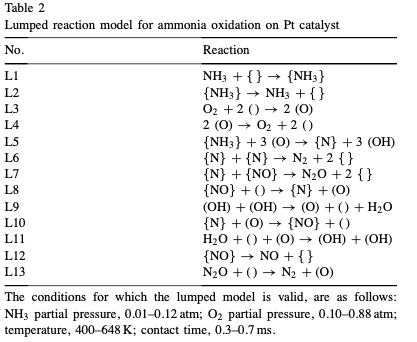

In [8]:
Image('Images/Rebrov_table2.png')

In [32]:
for commit in commit_list:
    data_dict[commit]['H3NX(29) + 3OX(10) <=> N_ads(64) + 3HOX(13)  ROP [kmol/m^2 s]'] = data_dict[commit]['H3NX(29) + OX(10) <=> H2NX(28) + HOX(13) ROP [kmol/m^2 s]'] + data_dict[commit]['H2NX(28) + OX(10) <=> HOX(13) + NH_ads(51) ROP [kmol/m^2 s]'] + data_dict[commit]['NH_ads(51) + OX(10) <=> HOX(13) + N_ads(64) ROP [kmol/m^2 s]']
L5 = ['H3NX(29) + 3OX(10) <=> N_ads(64) + 3HOX(13)  ROP [kmol/m^2 s]']
L6 = ['N2(4) + 2 X(1) <=> N2X2(25) ROP [kmol/m^2 s]'] #L6 is missing in master
L7 = [''] #L7 is missing in master
L13 = [''] #L7 is missing in master

### Figure 3
#### create partial pressure, selectivity, and concentration columns in the dataframe

In [7]:
#choose species partial pressures (for X-axis of plots) 
x_axis_nh3 = ['NH3(6)']

conversion_species = ['NH3(6)']
selectivity_species = ['N2(4)','N2O(7)','NO(5)']
# this is H-site adsorption. no way to tell that from cantera 
coverage_species_1 = ['OX(10)', 'HOX(13)', 'X(1)'] 

# this is N-site adsorption. no way to tell that from cantera
#coverage_species_2 = ['NOX(27)', 'NX(59)', 'H3NX(29)', 'X(1)']
coverage_species_2 = ['NO_ads(27)', 'N_ads(64)', 'H3NX(29)', 'X(1)']

In [22]:
# for commit in commit_list:
#     for i in conversion_species:
#         data_dict[commit]['NH3(6) conversion (%)'] = 100*(data_dict[commit]['X_nh3 initial'] - data_dict[commit][i])/data_dict[commit]['X_nh3 initial']

# #comment out, since NH3(6) partial pressure (atm) here is the same as X_nh3 initial
# # for commit in commit_list:
# #     data_dict[commit][f'NH3(6) partial pressure (atm)'] =  data_dict[commit]['X_nh3 initial']*data_dict[commit]['P (Pa)']/101325

# for commit in commit_list:
#     data_dict[commit]['O2(2) partial pressure (atm)'] =  data_dict[commit]['X_o2 initial']*(data_dict[commit]['P (Pa)']/101325)
#     data_dict[commit]['O2(2) partial pressure (atm)'] = data_dict[commit]['O2(2) partial pressure (atm)'].round(decimals=2)

# for commit in commit_list:
#     for i in selectivity_species:
#         data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])
#         selectivity = data_dict[commit][f'{i} Selectivity (%)']
        

In [8]:
for commit in commit_list:
    for i in conversion_species:
        data_dict[commit]['NH3(6) conversion (%)'] = 100*(data_dict[commit]['X_nh3 initial'] - data_dict[commit][i])/data_dict[commit]['X_nh3 initial']
    
    for i in selectivity_species:
        data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])

    for i in coverage_species_1:
        data_dict[commit][f'{i} Coverage'] = (data_dict[commit][i])/(data_dict[commit]['OX(10)'] + data_dict[commit]['HOX(13)']+ data_dict[commit]['X(1)'])
    
    for i in coverage_species_2:
        data_dict[commit][f'{i} Coverage'] = (data_dict[commit][i])/(data_dict[commit]['NO_ads(27)'] + data_dict[commit]['N_ads(64)']+ data_dict[commit]['H3NX(29)']+ data_dict[commit]['X(1)'])
            

In [9]:
data_dict[commit].to_csv("rebrov_NH3_data.csv")
data_dict[commit]

,Distance (mm),T (K),P (Pa),V (M^3/s),X_nh3 initial,X_o2 initial,X_he initial,(NH3/O2),T (K) final,Rtol,...,NH3(6) conversion (%),N2(4) Selectivity (%),N2O(7) Selectivity (%),NO(5) Selectivity (%),OX(10) Coverage,HOX(13) Coverage,X(1) Coverage,NO_ads(27) Coverage,N_ads(64) Coverage,H3NX(29) Coverage
1000,9.0,598,101325.0,2.771000e-08,0.011111,0.88,0.108889,0.012626,598.0,1.000000e-11,...,29.351487,49.861495,0.0,2.667552e-06,0.999500,2.673187e-09,0.006432,0.993546,0.000017,0.000005
1000,9.0,598,101325.0,2.771000e-08,0.012222,0.88,0.107778,0.013889,598.0,1.000000e-11,...,31.129060,49.847686,0.0,2.363825e-06,0.999465,2.867248e-09,0.006695,0.993282,0.000018,0.000005
1000,9.0,598,101325.0,2.771000e-08,0.013333,0.88,0.106667,0.015152,598.0,1.000000e-11,...,32.784129,49.833886,0.0,2.122430e-06,0.999431,3.053587e-09,0.006933,0.993042,0.000019,0.000006
1000,9.0,598,101325.0,2.771000e-08,0.014444,0.88,0.105556,0.016414,598.0,1.000000e-11,...,34.329262,49.820093,0.0,1.926422e-06,0.999398,3.232977e-09,0.007151,0.992824,0.000019,0.000006
1000,9.0,598,101325.0,2.771000e-08,0.015556,0.88,0.104444,0.017677,598.0,1.000000e-11,...,35.775390,49.806308,0.0,1.764383e-06,0.999367,3.406087e-09,0.007351,0.992622,0.000020,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,9.0,598,101325.0,2.771000e-08,0.115556,0.88,0.004444,0.131313,598.0,1.000000e-11,...,70.788622,48.596112,0.0,2.709979e-07,0.997896,1.210930e-08,0.012562,0.987366,0.000032,0.000040
1000,9.0,598,101325.0,2.771000e-08,0.116667,0.88,0.003333,0.132576,598.0,1.000000e-11,...,70.916109,48.582996,0.0,2.689658e-07,0.997885,1.218071e-08,0.012592,0.987336,0.000032,0.000040
1000,9.0,598,101325.0,2.771000e-08,0.117778,0.88,0.002222,0.133838,598.0,1.000000e-11,...,71.042030,48.569887,0.0,2.669693e-07,0.997873,1.225188e-08,0.012621,0.987306,0.000032,0.000040
1000,9.0,598,101325.0,2.771000e-08,0.118889,0.88,0.001111,0.135101,598.0,1.000000e-11,...,71.166418,48.556784,0.0,2.650073e-07,0.997861,1.232282e-08,0.012651,0.987276,0.000032,0.000041


<AxesSubplot:xlabel='X_nh3 initial', ylabel='NH3(6) conversion (%)'>

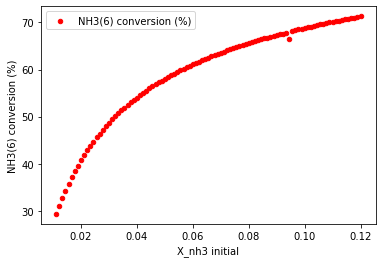

In [12]:
data_dict[commit].plot.scatter(x='X_nh3 initial',y='NH3(6) conversion (%)',label='NH3(6) conversion (%)',color="r")

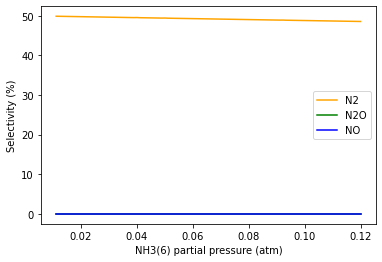

In [10]:
ax1 = data_dict[commit].plot(x='X_nh3 initial',y='N2(4) Selectivity (%)',
                                     label='N2',color="orange")
ax2 = data_dict[commit].plot(x='X_nh3 initial',y='N2O(7) Selectivity (%)',
                                     label='N2O',color='g', ax=ax1)
ax3 = data_dict[commit].plot(x='X_nh3 initial',y='NO(5) Selectivity (%)',
                                     label='NO',color='blue', ax=ax1)
ax1.set_xlabel("NH3(6) partial pressure (atm)")
ax1.set_ylabel("Selectivity (%)")
plt.show()

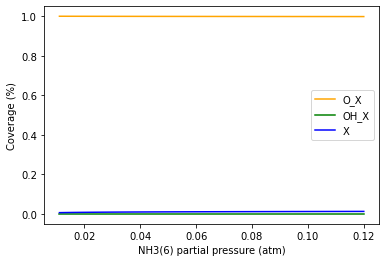

In [19]:
ax1 = data_dict[commit].plot(x='X_nh3 initial',y='OX(10) Coverage',
                                     label='O_X',color="orange")
ax2 = data_dict[commit].plot(x='X_nh3 initial',y='HOX(13) Coverage',
                                     label='OH_X',color='g', ax=ax1)
ax3 = data_dict[commit].plot(x='X_nh3 initial',y='X(1) Coverage',
                                     label='X',color='blue', ax=ax1)
ax1.set_xlabel("NH3(6) partial pressure (atm)")
ax1.set_ylabel("Coverage (%)")
plt.show()

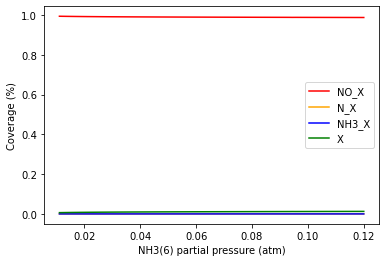

In [28]:
ax1 = data_dict[commit].plot(x='X_nh3 initial',y='NO_ads(27) Coverage',
                                     label='NO_X',color="r")
ax2 = data_dict[commit].plot(x='X_nh3 initial',y='N_ads(64) Coverage',
                                     label='N_X',color='orange', ax=ax1)
ax3 = data_dict[commit].plot(x='X_nh3 initial',y='H3NX(29) Coverage',
                                     label='NH3_X',color='b', ax=ax1)
ax4 = data_dict[commit].plot(x='X_nh3 initial',y='X(1) Coverage',
                                     label='X',color='g', ax=ax1)
ax1.set_xlabel("NH3(6) partial pressure (atm)")
ax1.set_ylabel("Coverage (%)")
plt.show()

In [123]:
for commit in commit_list:
    data_dict[commit][f'NH3(6) partial pressure (atm)'] =  data_dict[commit]['X_nh3 initial']*data_dict[commit]['P (Pa)']/101325
    
selectivity_species = [df_698K['NO(5) Selectivity (%)'],df_698K['N2O(7) Selectivity (%)'],df_698K['N2(4) Selectivity (%)']]

In [77]:
for commit in commit_list:
    data_dict[commit][f'NH3(6) partial pressure (atm)'] =  data_dict[commit]['X_nh3 initial']*data_dict[commit]['P (Pa)']/101325
    nh3_pressure = data_dict[commit][f'NH3(6) partial pressure (atm)']

In [63]:
for commit in commit_list:
    for i in selectivity_species:
        data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])
        selectivity = data_dict[commit][f'{i} Selectivity (%)']
        print(selectivity[0:108])
#         fig, ax = plt.subplots(len(selectivity),1,figsize=(10,30), constrained_layout = True)
#         color_dict = { 0:"r", 1:"gold", 2:"pink", 3:"yellowgreen",4:"lightskyblue"}
            
#         for p,j in enumerate(selectivity):
#             data_dict[commit][(data_dict[commit][f'{i} Selectivity (%)'] == j) &
#                              (data_dict[commit]['T (K)'] == temp)].plot.scatter(x='NH3(6) partial pressure (atm)', 
#                                                                                  y=selectivity[0:3], 
#                                                                                  label='NH3(6) conversion (%)', 
#                                                                                  ax=ax[p], 
#                                                                                  color="r")

#             ax[p].set_title(f'{commit} \nmole frac O2 = {j} \ntemperature {temp}')


1000    49.751244
1000    49.627792
1000    49.504950
1000    49.382716
1000    49.261084
          ...    
1000    49.028205
1000    48.899749
1000    48.780482
1000    48.661795
1000    48.543685
Name: N2(4) Selectivity (%), Length: 107, dtype: float64
1000    0.0
1000    0.0
1000    0.0
1000    0.0
1000    0.0
       ... 
1000    0.0
1000    0.0
1000    0.0
1000    0.0
1000    0.0
Name: N2O(7) Selectivity (%), Length: 107, dtype: float64
1000    8.623474e-08
1000    7.827234e-08
1000    7.398438e-08
1000    7.124887e-08
1000    6.932246e-08
            ...     
1000    1.466004e-05
1000    1.286029e-05
1000    1.143953e-05
1000    1.029474e-05
1000    9.352290e-06
Name: NO(5) Selectivity (%), Length: 107, dtype: float64


#### Selectivity and Coverage

In [62]:
for commit in commit_list:
    data_dict[commit]['NO selectivity (%)'] = 100*(data_dict[commit]['NO(5)'])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])
    #print(data_dict[commit]['NO selectivity (%)'])
    no_selectivity = data_dict[commit]['NO selectivity (%)'] 

    data_dict[commit]['N2O selectivity (%)'] = 100*(data_dict[commit]['N2O(7)'])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])
    #print(data_dict[commit]['N2O selectivity (%)'])
    n2o_selectivity = data_dict[commit]['N2O selectivity (%)']

    data_dict[commit]['N2 selectivity (%)'] = 100*(data_dict[commit]['N2(4)'])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])
    #print(data_dict[commit]['N2 selectivity (%)'])
    n2_selectivity = data_dict[commit]['N2 selectivity (%)']

    S_N2 = n2_selectivity/(n2_selectivity + no_selectivity + n2o_selectivity)*100
    S_NO = no_selectivity/(n2_selectivity + no_selectivity + n2o_selectivity)*100
    S_N2O = n2o_selectivity/(n2_selectivity + no_selectivity + n2o_selectivity)*100
    

#### NH3 initial partial pressure

In [78]:
for commit in commit_list:
    data_dict[commit][f'NH3(6) partial pressure (atm)'] =  data_dict[commit]['X_nh3 initial']*data_dict[commit]['P (Pa)']/101325
    nh3_pressure = data_dict[commit][f'NH3(6) partial pressure (atm)'] 

In [34]:
nh3_pressure

1000    0.02
1000    0.03
1000    0.04
1000    0.05
1000    0.06
        ... 
1000    0.08
1000    0.09
1000    0.10
1000    0.11
1000    0.12
Name: NH3(6) partial pressure (atm), Length: 107, dtype: float64

In [31]:
for i in selectivity_species:
    data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])
    print(data_dict[commit][f'{i} Selectivity (%)'])

1000    49.751244
1000    49.627792
1000    49.504950
1000    49.382716
1000    49.261084
          ...    
1000    49.028205
1000    48.899749
1000    48.780482
1000    48.661795
1000    48.543685
Name: N2(4) Selectivity (%), Length: 107, dtype: float64
1000    0.0
1000    0.0
1000    0.0
1000    0.0
1000    0.0
       ... 
1000    0.0
1000    0.0
1000    0.0
1000    0.0
1000    0.0
Name: N2O(7) Selectivity (%), Length: 107, dtype: float64
1000    8.623474e-08
1000    7.827234e-08
1000    7.398438e-08
1000    7.124887e-08
1000    6.932246e-08
            ...     
1000    1.466004e-05
1000    1.286029e-05
1000    1.143953e-05
1000    1.029474e-05
1000    9.352290e-06
Name: NO(5) Selectivity (%), Length: 107, dtype: float64


In [13]:
for commit in commit_list:
    for i in selectivity_species:
        data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])    
        selectivityNO = data_dict[commit][f'{i} Selectivity (%)']#.unique()
        selectivityN2O = data_dict[commit][f'{i+1} Selectivity (%)']
       # print(selectivity)
        plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
        plt.plot(nh3_pressure[0:10], selectivityNO[0:10],nh3_pressure[0:10], selectivityN2O[0:10])
        plt.xlabel('NH3(6) partial pressure (atm)',fontsize=15)
        plt.ylabel(f'{i} Selectivity (%)',fontsize=15)
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
        plt.title(f'{commit} \ntemperature {temp}',fontsize=15)
        plt.show()

TypeError: can only concatenate str (not "int") to str

In [ ]:
for commit in commit_list:
    
    for temp in temps:
        # get keys for O2 (X_o2 initial)
        o2_ratio = data_dict[commit_list[0]]['O2(2) partial pressure (atm)'].unique()

        # set figure size 
        fig, ax = plt.subplots(len(o2_ratio),1,figsize=(10,30), constrained_layout = True)

        # make a list of markers
        color_dict = { 0:"r", 1:"gold", 2:"pink", 3:"yellowgreen",4:"lightskyblue"}
    
        for p,j in enumerate(o2_ratio):
            data_dict[commit][(data_dict[commit]['O2(2) partial pressure (atm)'] == j) &
                             (data_dict[commit]['T (C)'] == temp)].plot.scatter(x='NH3(6) partial pressure (atm)', 
                                                                                 y='NH3(6) conversion (%)', 
                                                                                 label='NH3(6) conversion (%)', 
                                                                                 ax=ax[p], 
                                                                                 color="r")

            ax[p].set_title(f'{commit} \nmole frac O2 = {j} \ntemperature {temp}')


In [27]:
for commit in commit_list:
    for m in x_axis_nh3:
        temps = data_dict[commit_list[0]]['T (K)'].unique()
       # print(temps)
        for i in selectivity_species:
            data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])
            #print(data_dict[commit][f'{i} Selectivity (%)'])
            for temp in temps:
                Selectivity1 = data_dict[commit][i]
                #print(f'{i} Selectivity (%) is {Selectivity1} at T = {temp}')
                for p,j in enumerate(Selectivity1):
                    data_dict[commit][(data_dict[commit][i] == j) &
                                 (data_dict[commit]['T (K)'] == temp)].plot.scatter(x='NH3(6) partial pressure (atm)', 
                                                                                     y=Selectivity1, 
                                                                                     label='Selectivity(%)', 
                                                                                     ax=ax[p], 
                                                                                     color="r")

                    ax[p].set_title(f'{commit} \nmole Selectivity {i} = {j} \ntemperature {temp}')

KeyError: "None of [Float64Index([0.00018915905639807119, 0.00022457413935150742,\n              0.00024778626023020143,  0.0002642709378084195,\n               0.0002766180455709284,   0.000286228658293318,\n              0.00029393184846925166, 0.00030025123518933564,\n               0.0003055344458896611, 0.00031002160787221524,\n              ...\n                 0.00987549050495128,   0.014343714992602119,\n                  0.0189351386496281,   0.023592924481496573,\n                0.028286693178647536,   0.032999071312277056,\n                0.037717865476575234,    0.04243692157818962,\n                 0.04715089513718092,    0.05185627623811077],\n             dtype='float64', length=107)] are in the [columns]"

In [28]:
df_t_225_02_0_88_data_dict=data_dict[commit][(data_dict[commit]['O2(2) partial pressure (atm)'] == 0.88) &
                             (data_dict[commit]['T (C)'] == 225)]

In [29]:
df_t_225_02_0_88_data_dict

,Distance (mm),T (C),P (Pa),V (M^3/s),X_nh3 initial,X_o2 initial,X_he initial,(NH3/O2),T (C) final,Rtol,...,HNOX(136) + NO2X2(466) <=> NO_X(26) + SX(146) ROP [kmol/m^2 s],SX(146) + X(1) <=> HOX(13) + NOX2(132) ROP [kmol/m^2 s].1,N_X(25) + SX(146) <=> HNOX(136) + NOX2(132) ROP [kmol/m^2 s].2,N_X(25) + SX(146) <=> HNOX(136) + NOX2(132) ROP [kmol/m^2 s].3,NO2(30) + 2 X(1) <=> NO2X2(248) ROP [kmol/m^2 s],NO2X2(248) + OX(10) <=> NOX2(132) + O2X(731) ROP [kmol/m^2 s],NH3(6) conversion (%),NO(5) selectivity (%),NH3(6) partial pressure (atm),O2(2) partial pressure (atm)
921,8280.0,225,101325.0,2.715500e-08,0.010,0.88,0.110,0.011364,225.0,1.000000e-08,...,-5.168881e-72,3.417907e-61,2.962649e-47,2.962649e-47,6.222660e-58,4.630594e-58,2.585369e-06,1.515396e-29,0.010,0.88
235,2106.0,225,101325.0,2.715500e-08,0.020,0.88,0.100,0.022727,225.0,1.000000e-08,...,1.829502e-59,-2.670272e-57,-3.464858e-43,-3.464858e-43,-3.819620e-65,-2.691550e-66,-1.309972e-05,-5.140747e-38,0.020,0.88
420,3771.0,225,101325.0,2.715500e-08,0.025,0.88,0.095,0.028409,225.0,1.000000e-08,...,2.851775e-47,1.011025e-50,1.509520e-36,1.509520e-36,2.184174e-54,4.229134e-55,-2.642432e-06,-5.146292e-36,0.025,0.88
98,873.0,225,101325.0,2.715500e-08,0.070,0.88,0.050,0.079545,225.0,1.000000e-08,...,1.661289e-72,0.000000e+00,0.000000e+00,0.000000e+00,-7.709948e-74,3.998287e-70,-1.745461e-07,-4.312019e-35,0.070,0.88


<AxesSubplot:xlabel='NH3(6) partial pressure (atm)', ylabel='NH3(6) conversion (%)'>

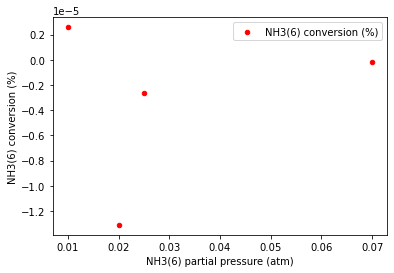

In [31]:
df_t_225_02_0_88_data_dict.plot.scatter(x='NH3(6) partial pressure (atm)', 
                                        y='NH3(6) conversion (%)', 
                                        label='NH3(6) conversion (%)', 
                                        color="r")

In [ ]:
#If set up different temp ranges
df_498K = data_dict[commit][data_dict[commit]['T (K)'] == 498]
df_523K = data_dict[commit][data_dict[commit]['T (K)'] == 523]
df_548K = data_dict[commit][data_dict[commit]['T (K)'] == 548]
df_573K = data_dict[commit][data_dict[commit]['T (K)'] == 573]
df_598K = data_dict[commit][data_dict[commit]['T (K)'] == 598]
df_623K = data_dict[commit][data_dict[commit]['T (K)'] == 623]
df_648K = data_dict[commit][data_dict[commit]['T (K)'] == 648]
df_698K = data_dict[commit][data_dict[commit]['T (K)'] == 698]

fig = plt.figure()
ax = plt.axes()
#plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
plt.plot(df_698K['X_nh3 initial'], df_698K['N2(4) Selectivity (%)'], label = 'N2')
plt.plot(df_698K['X_nh3 initial'], df_698K['N2O(7) Selectivity (%)'], label = 'N2O')
plt.plot(df_698K['X_nh3 initial'], 1e5*df_698K['NO(5) Selectivity (%)'], label = 'NO')
plt.xlabel('NH3')
plt.ylabel('Selectivity')
plt.title('X_NH3 v.s. Selectivity Plot ')
plt.legend()

plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
plt.plot(nh3_pressure[0:11], 1e5*no_selectivity[96:107],label= "NO*e5")
plt.plot(nh3_pressure[0:11], 1e5*n2o_selectivity[96:107],label= "N2O*e5")
plt.plot(nh3_pressure[0:11], n2_selectivity[96:107],label= "N2")
plt.xlabel('NH3(6) partial pressure (atm)',fontsize=15)
plt.ylabel('Selectivity (%)',fontsize=15)
plt.minorticks_on()
plt.title('Temperature = 698K' ,fontsize=15)
plt.legend()

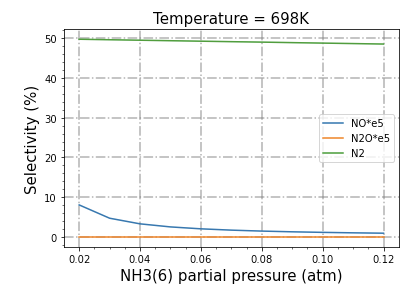
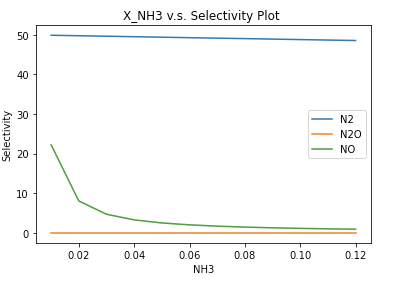